# Rebuild Shared Preprocessed Cache

**Run this notebook ONCE before training to build shared cached data.**

This notebook creates preprocessed cached data in `shared/preprocessed_data/` from the dataset in `shared/dataset/`.
All experiment variants (accuracy_focus, efficient_focus) can use this shared cache.


## Step 1: Import Libraries

In [14]:
import os
import sys
import shutil
from pathlib import Path
import torch

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Add shared modules to path
shared_path = project_root / 'shared'
sys.path.insert(0, str(shared_path))

from shared.configs.config_loader import load_config
from shared.src.data import CachedHC18Dataset
from shared.src.utils import get_transforms

print(f"✓ Imports successful")
print(f"✓ Project root: {project_root}")
print(f"✓ Shared modules: {shared_path}")
print(f"✓ Working directory: {Path.cwd()}")


✓ Imports successful
✓ Project root: e:\Fetal Head Segmentation
✓ Shared modules: e:\Fetal Head Segmentation\shared
✓ Working directory: e:\Fetal Head Segmentation\notebooks


## Step 2: Load Configuration

In [16]:
# Load configuration (using shared config)
config_path = project_root / 'shared' / 'configs' / 'augmentation_config.yaml'
print(f"Loading config from: {config_path}")

config = load_config(str(config_path))

# Extract config values
data_cfg = config['data']
aug_cfg = config['augmentation']

# Get image size
img_size = aug_cfg['preprocessing']['image_size'][0]

# Convert relative paths to absolute paths
def make_absolute(path):
    """Convert relative path to absolute from project root."""
    p = Path(path)
    if not p.is_absolute():
        return str(project_root / path)
    return str(p)

# Update data paths to absolute (using shared dataset)
data_cfg['train_images'] = make_absolute('shared/dataset/training_set/images')
data_cfg['train_masks'] = make_absolute('shared/dataset/training_set/masks')
data_cfg['val_images'] = make_absolute('shared/dataset/validation_set/images')
data_cfg['val_masks'] = make_absolute('shared/dataset/validation_set/masks')
data_cfg['test_images'] = make_absolute('shared/dataset/test_set/images')
data_cfg['test_masks'] = make_absolute('shared/dataset/test_set/masks')

print(f"\n✓ Configuration loaded")
print(f"  Image size: {img_size}x{img_size}")
print(f"  Training images: {data_cfg['train_images']}")
print(f"  Training masks: {data_cfg['train_masks']}")
print(f"  Validation images: {data_cfg['val_images']}")
print(f"  Validation masks: {data_cfg['val_masks']}")
print(f"  Test images: {data_cfg['test_images']}")
print(f"  Test masks: {data_cfg['test_masks']}")


Loading config from: e:\Fetal Head Segmentation\shared\configs\augmentation_config.yaml

✓ Configuration loaded
  Image size: 256x256
  Training images: e:\Fetal Head Segmentation\shared\dataset\training_set\images
  Training masks: e:\Fetal Head Segmentation\shared\dataset\training_set\masks
  Validation images: e:\Fetal Head Segmentation\shared\dataset\validation_set\images
  Validation masks: e:\Fetal Head Segmentation\shared\dataset\validation_set\masks
  Test images: e:\Fetal Head Segmentation\shared\dataset\test_set\images
  Test masks: e:\Fetal Head Segmentation\shared\dataset\test_set\masks


## Step 3: Clean Existing Cache

In [17]:
# Define preprocessed data directory (shared)
preprocessed_dir = project_root / 'shared' / 'preprocessed_data'

print("="*70)
print("CLEANING EXISTING CACHE")
print("="*70)

# Check if cache exists
if preprocessed_dir.exists():
    # List subdirectories and file counts
    subdirs = list(preprocessed_dir.iterdir())
    if subdirs:
        print(f"\nFound {len(subdirs)} cache directories:")
        for subdir in subdirs:
            if subdir.is_dir():
                num_files = len(list(subdir.glob('*.npz')))
                print(f"  - {subdir.name}: {num_files} files")
        
        # Delete entire directory
        print(f"\n⚠️  Deleting: {preprocessed_dir}")
        shutil.rmtree(preprocessed_dir)
        print(f"✓ Deleted successfully")
    else:
        print(f"\n✓ Cache directory is empty: {preprocessed_dir}")
else:
    print(f"\n✓ No existing cache found at: {preprocessed_dir}")

# Recreate empty directory
preprocessed_dir.mkdir(exist_ok=True)
print(f"✓ Created fresh directory: {preprocessed_dir}")
print("="*70)


CLEANING EXISTING CACHE

Found 3 cache directories:
  - test_cache: 150 files
  - train_cache: 799 files
  - val_cache: 50 files

⚠️  Deleting: e:\Fetal Head Segmentation\shared\preprocessed_data
✓ Deleted successfully
✓ Created fresh directory: e:\Fetal Head Segmentation\shared\preprocessed_data


## Step 4: Rebuild Training Cache

In [18]:
print("\n" + "="*70)
print("REBUILDING TRAINING CACHE")
print("="*70)

# Get transforms (without augmentation for cache - augmentation is applied on-the-fly)
train_transforms = get_transforms(img_size, img_size, is_train=False)

# Define cache path
train_cache_path = preprocessed_dir / 'train_cache'

# Build training cache
print(f"\nBuilding cache at: {train_cache_path}")
print(f"Source images: {data_cfg['train_images']}")
print(f"Source masks: {data_cfg['train_masks']}\n")

train_dataset = CachedHC18Dataset(
    image_dir=data_cfg['train_images'],
    mask_dir=data_cfg['train_masks'],
    cache_dir=str(train_cache_path),
    img_height=img_size,
    img_width=img_size,
    transform=train_transforms,
    force_rebuild=True  # Force rebuild to apply bug fixes
)

print(f"\n✓ Training cache built successfully")
print(f"  Total samples: {len(train_dataset)}")
print(f"  Cache location: {train_cache_path}")
print("="*70)


REBUILDING TRAINING CACHE

Building cache at: e:\Fetal Head Segmentation\shared\preprocessed_data\train_cache
Source images: e:\Fetal Head Segmentation\shared\dataset\training_set\images
Source masks: e:\Fetal Head Segmentation\shared\dataset\training_set\masks

Building cache: e:\Fetal Head Segmentation\shared\preprocessed_data\train_cache
Preprocessing 799 image-mask pairs...


Caching:   0%|          | 0/799 [00:00<?, ?it/s]

Caching: 100%|██████████| 799/799 [00:14<00:00, 55.63it/s]

Cache built successfully: 799 samples

✓ Training cache built successfully
  Total samples: 799
  Cache location: e:\Fetal Head Segmentation\shared\preprocessed_data\train_cache


## Step 5: Rebuild Validation Cache

In [19]:
print("\n" + "="*70)
print("REBUILDING VALIDATION CACHE")
print("="*70)

# Get transforms (no augmentation for validation)
val_transforms = get_transforms(img_size, img_size, is_train=False)

# Define cache path
val_cache_path = preprocessed_dir / 'val_cache'

# Build validation cache
print(f"\nBuilding cache at: {val_cache_path}")
print(f"Source images: {data_cfg['val_images']}")
print(f"Source masks: {data_cfg['val_masks']}\n")

val_dataset = CachedHC18Dataset(
    image_dir=data_cfg['val_images'],
    mask_dir=data_cfg['val_masks'],
    cache_dir=str(val_cache_path),
    img_height=img_size,
    img_width=img_size,
    transform=val_transforms,
    force_rebuild=True  # Force rebuild to apply bug fixes
)

print(f"\n✓ Validation cache built successfully")
print(f"  Total samples: {len(val_dataset)}")
print(f"  Cache location: {val_cache_path}")
print("="*70)


REBUILDING VALIDATION CACHE

Building cache at: e:\Fetal Head Segmentation\shared\preprocessed_data\val_cache
Source images: e:\Fetal Head Segmentation\shared\dataset\validation_set\images
Source masks: e:\Fetal Head Segmentation\shared\dataset\validation_set\masks

Building cache: e:\Fetal Head Segmentation\shared\preprocessed_data\val_cache
Preprocessing 50 image-mask pairs...


Caching: 100%|██████████| 50/50 [00:00<00:00, 54.57it/s]

Cache built successfully: 50 samples

✓ Validation cache built successfully
  Total samples: 50
  Cache location: e:\Fetal Head Segmentation\shared\preprocessed_data\val_cache


## Step 6: Rebuild Test Cache

In [20]:
print("\n" + "="*70)
print("REBUILDING TEST CACHE")
print("="*70)

# Get transforms (no augmentation for test)
test_transforms = get_transforms(img_size, img_size, is_train=False)

# Define cache path
test_cache_path = preprocessed_dir / 'test_cache'

# Build test cache
print(f"\nBuilding cache at: {test_cache_path}")
print(f"Source images: {data_cfg['test_images']}")
print(f"Source masks: {data_cfg['test_masks']}\n")

test_dataset = CachedHC18Dataset(
    image_dir=data_cfg['test_images'],
    mask_dir=data_cfg['test_masks'],
    cache_dir=str(test_cache_path),
    img_height=img_size,
    img_width=img_size,
    transform=test_transforms,
    force_rebuild=True  # Force rebuild to apply bug fixes
)

print(f"\n✓ Test cache built successfully")
print(f"  Total samples: {len(test_dataset)}")
print(f"  Cache location: {test_cache_path}")
print("="*70)


REBUILDING TEST CACHE

Building cache at: e:\Fetal Head Segmentation\shared\preprocessed_data\test_cache
Source images: e:\Fetal Head Segmentation\shared\dataset\test_set\images
Source masks: e:\Fetal Head Segmentation\shared\dataset\test_set\masks

Building cache: e:\Fetal Head Segmentation\shared\preprocessed_data\test_cache
Preprocessing 150 image-mask pairs...


Caching: 100%|██████████| 150/150 [00:02<00:00, 54.10it/s]

Cache built successfully: 150 samples

✓ Test cache built successfully
  Total samples: 150
  Cache location: e:\Fetal Head Segmentation\shared\preprocessed_data\test_cache


## Step 7: Verify Cache Integrity

In [21]:
print("\n" + "="*70)
print("VERIFYING CACHE INTEGRITY")
print("="*70)

# Check each cache directory
cache_dirs = {
    'Training': train_cache_path,
    'Validation': val_cache_path,
    'Test': test_cache_path
}

for name, cache_path in cache_dirs.items():
    if cache_path.exists():
        num_files = len(list(cache_path.glob('*.npz')))
        metadata_exists = (cache_path / 'metadata.pkl').exists()
        print(f"\n{name} Cache:")
        print(f"  ✓ Path: {cache_path}")
        print(f"  ✓ Files: {num_files} .npz files")
        print(f"  ✓ Metadata: {'Found' if metadata_exists else 'Missing'}")
    else:
        print(f"\n{name} Cache:")
        print(f"  ✗ Not found at: {cache_path}")

print("\n" + "="*70)


VERIFYING CACHE INTEGRITY

Training Cache:
  ✓ Path: e:\Fetal Head Segmentation\shared\preprocessed_data\train_cache
  ✓ Files: 799 .npz files
  ✓ Metadata: Found

Validation Cache:
  ✓ Path: e:\Fetal Head Segmentation\shared\preprocessed_data\val_cache
  ✓ Files: 50 .npz files
  ✓ Metadata: Found

Test Cache:
  ✓ Path: e:\Fetal Head Segmentation\shared\preprocessed_data\test_cache
  ✓ Files: 150 .npz files
  ✓ Metadata: Found



## Step 8: Test Data Loading

In [22]:
print("\n" + "="*70)
print("TESTING DATA LOADING")
print("="*70)

# Load a sample from training cache
sample_image, sample_mask = train_dataset[0]

print(f"\nSample from training cache:")
print(f"  Image shape: {sample_image.shape}")
print(f"  Image dtype: {sample_image.dtype}")
print(f"  Image range: [{sample_image.min():.4f}, {sample_image.max():.4f}]")
print(f"  Mask shape: {sample_mask.shape}")
print(f"  Mask dtype: {sample_mask.dtype}")
print(f"  Mask unique values: {torch.unique(sample_mask).tolist()}")
print(f"  Mask range: [{sample_mask.min():.4f}, {sample_mask.max():.4f}]")

# Verify mask is binary
unique_values = torch.unique(sample_mask)
is_binary = len(unique_values) == 2 and set(unique_values.tolist()) == {0.0, 1.0}

if is_binary:
    print(f"\n✓ Mask is correctly binarized [0.0, 1.0]")
else:
    print(f"\n⚠️  WARNING: Mask has unexpected values: {unique_values.tolist()}")

print("="*70)


TESTING DATA LOADING

Sample from training cache:
  Image shape: torch.Size([1, 256, 256])
  Image dtype: torch.float32
  Image range: [0.0000, 0.9529]
  Mask shape: torch.Size([1, 256, 256])
  Mask dtype: torch.float32
  Mask unique values: [0.0, 1.0]
  Mask range: [0.0000, 1.0000]

✓ Mask is correctly binarized [0.0, 1.0]


## Step 9: Visualize Sample


Visualizing samples from training cache...

Sample 1:
  Image: min=0.0000, max=0.9529, mean=0.1168
  Mask:  values=[0.0, 1.0], foreground ratio=0.0038
Sample 2:
  Image: min=0.0000, max=0.9922, mean=0.1496
  Mask:  values=[0.0, 1.0], foreground ratio=0.0091
Sample 3:
  Image: min=0.0000, max=0.9529, mean=0.1279
  Mask:  values=[0.0, 1.0], foreground ratio=0.0077
Sample 4:
  Image: min=0.0000, max=0.9529, mean=0.0727
  Mask:  values=[0.0, 1.0], foreground ratio=0.0057


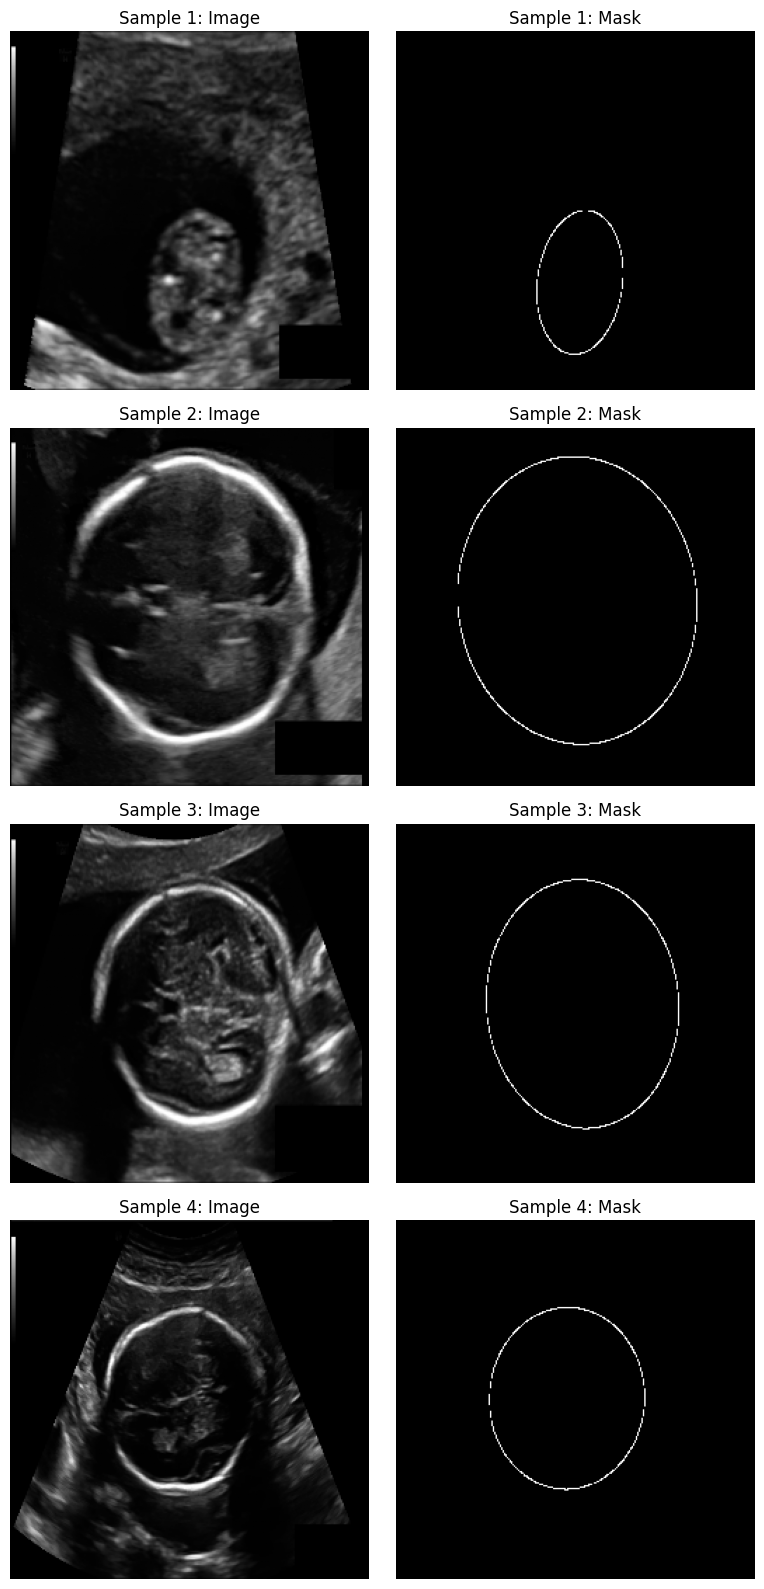


✓ Visualization complete


In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize a few samples
num_samples = 4
fig, axes = plt.subplots(num_samples, 2, figsize=(8, 4*num_samples))

print("\nVisualizing samples from training cache...\n")

for i in range(num_samples):
    image, mask = train_dataset[i * (len(train_dataset) // num_samples)]
    
    # Convert to numpy
    img_np = image.squeeze().numpy()
    mask_np = mask.squeeze().numpy()
    
    # Display image
    axes[i, 0].imshow(img_np, cmap='gray')
    axes[i, 0].set_title(f'Sample {i+1}: Image')
    axes[i, 0].axis('off')
    
    # Display mask
    axes[i, 1].imshow(mask_np, cmap='gray')
    axes[i, 1].set_title(f'Sample {i+1}: Mask')
    axes[i, 1].axis('off')
    
    # Print statistics
    print(f"Sample {i+1}:")
    print(f"  Image: min={img_np.min():.4f}, max={img_np.max():.4f}, mean={img_np.mean():.4f}")
    print(f"  Mask:  values={np.unique(mask_np).tolist()}, foreground ratio={mask_np.mean():.4f}")

plt.tight_layout()
plt.show()

print("\n✓ Visualization complete")